### ***--> Installing the required libraries***

In [1]:
pip install pandas matplotlib seaborn prophet scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

### ***--> Loading Daily Data***

In [3]:
monthly_data = pd.read_csv("C:/Users/Saiku/Downloads/SN_m_tot_V2.0.csv", delimiter=';', header=None)
monthly_data.columns = ["Year", "Month", "FractionalYear", "MonthlyMeanSunspotNumber", "StdDev", "Observations", "Indicator"]
monthly_data = monthly_data[monthly_data["MonthlyMeanSunspotNumber"] != -1]  # Remove missing values
monthly_data['Date'] = pd.to_datetime(monthly_data[['Year', 'Month']].assign(Day=1))
monthly_data = monthly_data[['Date', "MonthlyMeanSunspotNumber"]].rename(columns={'Date': 'ds', "MonthlyMeanSunspotNumber": 'y'})

In [4]:
monthly_data['y'] = monthly_data['y'].replace(0, 1e-6)  # Replace zeros with a small positive value

In [5]:
monthly_data['y'] = monthly_data['y'].apply(lambda x: np.log(x + 1e-6))  # Log transform with small constant

In [6]:
monthly_data = monthly_data[monthly_data['y'] > 0]  # Remove zero values

###***--> Training the FBProphet Model***

In [7]:
# Initialize Prophet Model
monthly_model = Prophet()

# Fit the model
monthly_model.fit(monthly_data)

# Create future dataframe (9 months)
future_monthly = monthly_model.make_future_dataframe(periods=9, freq='M')

# Predict
forecast_monthly = monthly_model.predict(future_monthly)

13:37:05 - cmdstanpy - INFO - Chain [1] start processing
13:37:06 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Saiku\AppData\Roaming\Python\Python312\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


C:\Users\Saiku\AppData\Roaming\Python\Python312\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


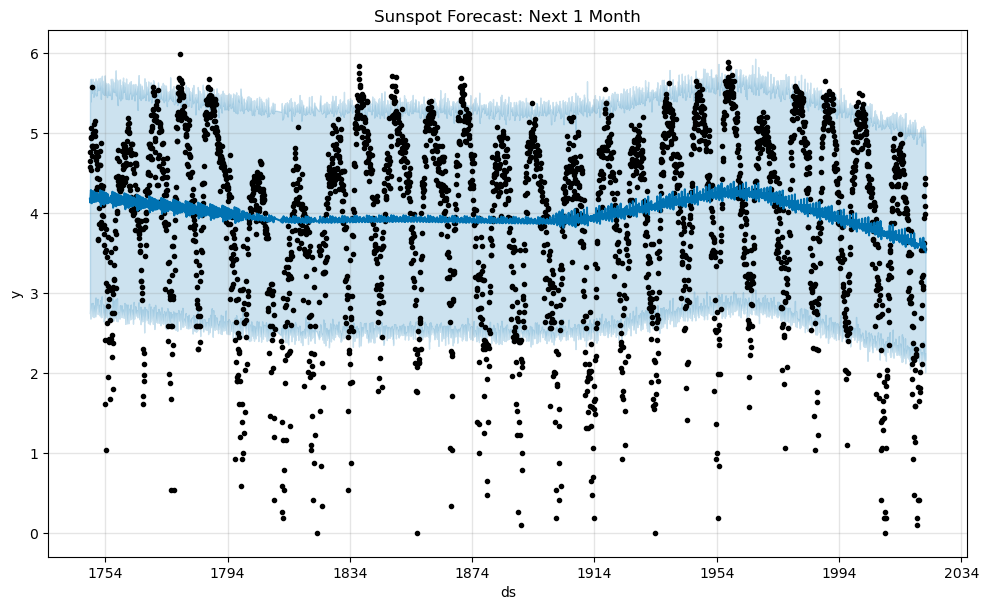

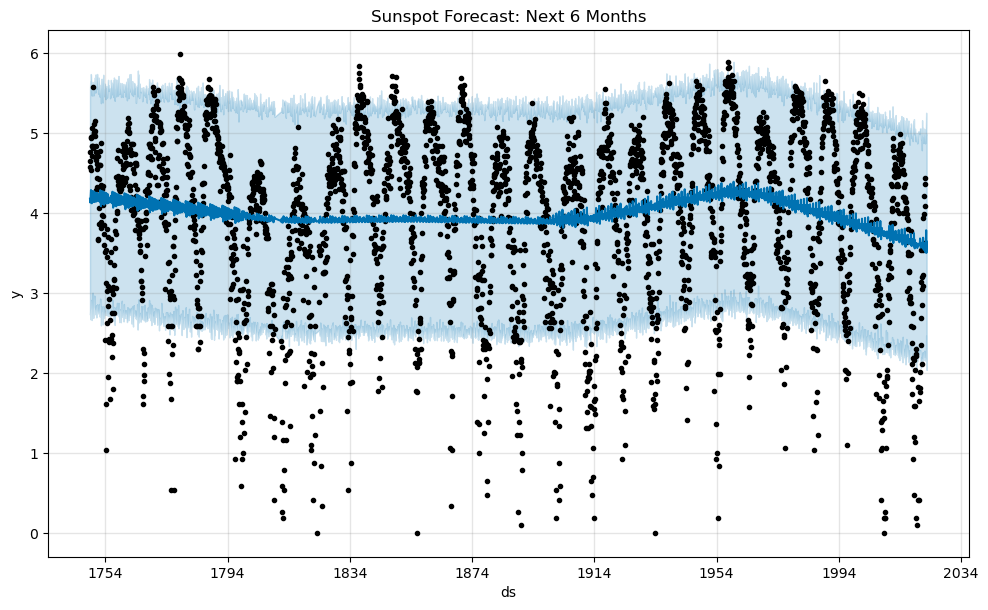

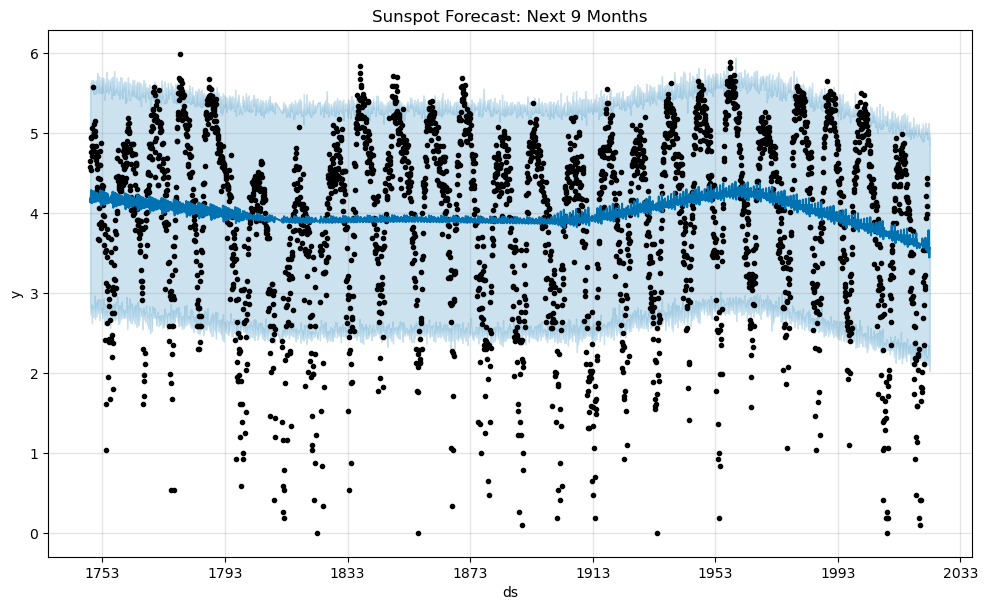

In [8]:
# Predict for 1, 6, and 9 months
future_monthly_1 = monthly_model.make_future_dataframe(periods=1, freq='M')
future_monthly_6 = monthly_model.make_future_dataframe(periods=6, freq='M')
future_monthly_9 = monthly_model.make_future_dataframe(periods=9, freq='M')

# Predict 1 month
forecast_monthly_1 = monthly_model.predict(future_monthly_1)

# Predict 6 months
forecast_monthly_6 = monthly_model.predict(future_monthly_6)

# Predict 9 months
forecast_monthly_9 = monthly_model.predict(future_monthly_9)

# Visualize predictions for each forecast
fig_1 = monthly_model.plot(forecast_monthly_1)
plt.title("Sunspot Forecast: Next 1 Month")
plt.show()

fig_6 = monthly_model.plot(forecast_monthly_6)
plt.title("Sunspot Forecast: Next 6 Months")
plt.show()

fig_9 = monthly_model.plot(forecast_monthly_9)
plt.title("Sunspot Forecast: Next 9 Months")
plt.show()

In [9]:
# For 1 month prediction
print("Predicted values for the next 1 month:")
print(forecast_monthly_1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(1))

# For 6 months prediction
print("Predicted values for the next 6 months:")
print(forecast_monthly_6[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6))

# For 9 months prediction
print("Predicted values for the next 9 months:")
print(forecast_monthly_9[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(9))

Predicted values for the next 1 month:
             ds      yhat  yhat_lower  yhat_upper
3169 2022-04-30  3.507254    2.168109    4.862556
Predicted values for the next 6 months:
             ds      yhat  yhat_lower  yhat_upper
3169 2022-04-30  3.507254    2.150572    4.877795
3170 2022-05-31  3.583556    2.167288    5.016099
3171 2022-06-30  3.579150    2.188740    5.070824
3172 2022-07-31  3.782673    2.465171    5.251822
3173 2022-08-31  3.498890    2.076812    4.977142
3174 2022-09-30  3.639754    2.036141    4.986229
Predicted values for the next 9 months:
             ds      yhat  yhat_lower  yhat_upper
3169 2022-04-30  3.507254    2.095511    4.920890
3170 2022-05-31  3.583556    2.201706    4.986709
3171 2022-06-30  3.579150    2.211679    4.961515
3172 2022-07-31  3.782673    2.350023    5.121743
3173 2022-08-31  3.498890    2.122055    4.928198
3174 2022-09-30  3.639754    2.290135    5.036465
3175 2022-10-31  3.441074    2.056861    4.859200
3176 2022-11-30  3.566743    2.

###***--> Visualizing Predictions***

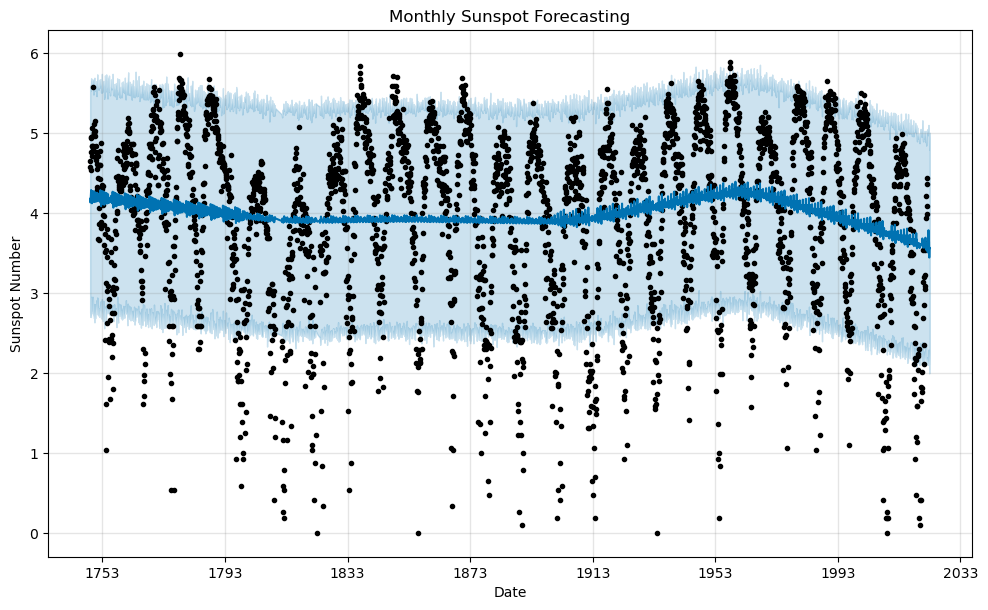

In [10]:
fig = monthly_model.plot(forecast_monthly)
plt.title("Monthly Sunspot Forecasting")
plt.xlabel("Date")
plt.ylabel("Sunspot Number")
plt.show()

### ***--> Tune Hyperparameters : Adding custom seasonality***

In [11]:
monthly_model = Prophet(growth='linear', changepoint_prior_scale=0.05)
monthly_model.add_seasonality(name='yearly', period=12, fourier_order=10)

# Fit and Predict again
monthly_model.fit(monthly_data)
forecast_monthly = monthly_model.predict(future_monthly)

13:37:46 - cmdstanpy - INFO - Chain [1] start processing
13:37:47 - cmdstanpy - INFO - Chain [1] done processing


###***--> Evaluating Model Performance***

In [12]:
y_true = monthly_data['y'].tail(9)
y_pred = forecast_monthly['yhat'][-9:]

mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae}, MAPE: {mape}, R²: {r2}")

MAE: 0.4728778784064581, MAPE: 0.11664747570952508, R²: -0.8436954010352451
